# What will be the best location to pick-up customers for each day of the week of a month?


As a taxi driver, you always want to know where is the best location to pick up customers. The more customers you get the more profit you earn. In this project, we will use Kmeans Clustering and Polynomial Regression to predict best location for a taxi driver.

## Preamble

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

## Load the data
you can get data from this [link](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-01.csv)

In [2]:
df=pd.read_csv("datasets/yellow_tripdata_2013-01.csv")

## Preprocess data
Since our data is large and exist some ourliers, we have to do preprocess for our data. We need to reduce size of our data and get rid off some ourliers for our data.

In [3]:
#create new column call weekday
timestamp = pd.to_datetime(pd.Series(df['pickup_datetime']))
df['weekday'] = timestamp.dt.weekday_name
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,weekday
0,CMT,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,1,N,-73.989840,40.751173,CSH,6.5,0.0,0.5,0.0,0.0,7.0,Tuesday
1,CMT,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,1,N,-73.994499,40.750659,CSH,6.0,0.5,0.5,0.0,0.0,7.0,Sunday
2,CMT,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,1,N,-74.009831,40.726000,CSH,5.5,1.0,0.5,0.0,0.0,7.0,Saturday
3,CMT,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,1,N,-73.984737,40.759388,CSH,5.0,0.5,0.5,0.0,0.0,6.0,Monday
4,CMT,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,1,N,-74.002583,40.747867,CSH,9.5,0.5,0.5,0.0,0.0,10.5,Monday


In [4]:
#drop unnecessary column
df = df.drop(['vendor_id','passenger_count','trip_distance','rate_code',
              'store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','dropoff_datetime',
              'dropoff_longitude','dropoff_latitude'], axis=1)

#get rid off some garbage data
df=df[(df['pickup_latitude'] > 40.492083) & (df['pickup_latitude']<40.944536) &
     (df['pickup_longitude']> -74.267880)& (df['pickup_longitude']< -73.662022)]

df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,weekday
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday
1,2013-01-06 00:18:35,-74.006680,40.731781,Sunday
2,2013-01-05 18:49:41,-74.004711,40.737770,Saturday
3,2013-01-07 23:54:15,-73.974600,40.759945,Monday
4,2013-01-07 23:25:03,-73.976252,40.748528,Monday


In [5]:
#get all the selected weekdays in selected month
my_weekday="Thursday"
my_montn=1
df_select=df[(df['weekday']==my_weekday) & 
                 (pd.to_datetime(df['pickup_datetime']) < pd.datetime(2013,my_montn+1,1))&
                (pd.to_datetime(df['pickup_datetime']) > pd.datetime(2013,my_montn,1))]
df_select=df_select[:70000]
df_select.head()

,pickup_datetime,pickup_longitude,pickup_latitude,weekday
12,2013-01-10 12:07:08,-73.971497,40.791319,Thursday
14,2013-01-10 15:42:29,-73.994913,40.723219,Thursday
15,2013-01-10 14:27:28,-74.010394,40.708702,Thursday
20,2013-01-10 23:41:51,-73.783310,40.648765,Thursday
175,2013-01-10 12:20:38,-73.966660,40.773125,Thursday


## Kmean Clustering
We use Kmean to divide our data into 100 clusters. We use these 100 clusters to represent 100 blocks in New York City. We look into size of clusters and center of clusters

In [6]:
%%time
#use Kmean to group data by longitude and latitude
my_cluster=100
from sklearn.cluster import KMeans
lon=df_select['pickup_longitude'].values
lat=df_select['pickup_latitude'].values
coodinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])

kmeans_n = KMeans(n_clusters=my_cluster,  n_init=1, random_state=1000)
kmeans_n.fit(coodinate_array)
labels = kmeans_n.labels_
print(labels)

[79 20 28 ..., 98 31 23]
CPU times: user 7.26 s, sys: 1.37 s, total: 8.63 s
Wall time: 5.38 s


In [7]:
# add new column call cluster
df_select['Cluster']=labels
df_select.head()

,pickup_datetime,pickup_longitude,pickup_latitude,weekday,Cluster
12,2013-01-10 12:07:08,-73.971497,40.791319,Thursday,79
14,2013-01-10 15:42:29,-73.994913,40.723219,Thursday,20
15,2013-01-10 14:27:28,-74.010394,40.708702,Thursday,28
20,2013-01-10 23:41:51,-73.783310,40.648765,Thursday,2
175,2013-01-10 12:20:38,-73.966660,40.773125,Thursday,82


In [8]:
#prepare for regression
Cluster_size=df_select.groupby('Cluster').size()
Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
Cluster_center=kmeans_n.cluster_centers_

## Analysis

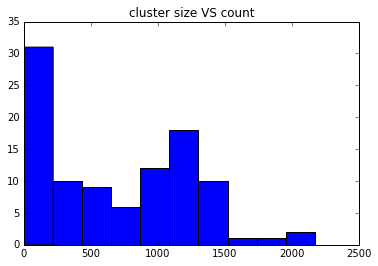

In [9]:
plt.hist(Cluster_size)
plt.title("cluster size VS count")
plt.show()

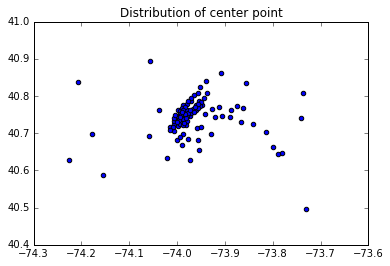

In [10]:
analysis_lon=[]
analysis_lat=[]
for i in range(len(Cluster_center)):
    analysis_lon.append(Cluster_center[i][0])
    analysis_lat.append(Cluster_center[i][1])
plt.scatter(analysis_lon,analysis_lat)
plt.title("Distribution of center point")
plt.show()

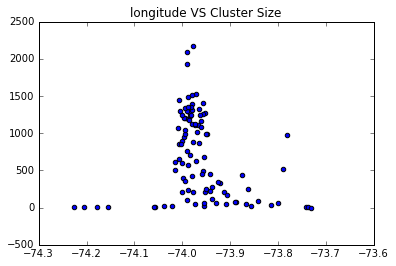

In [11]:
plt.scatter(analysis_lon,Cluster_size)
plt.title("longitude VS Cluster Size")
plt.show()

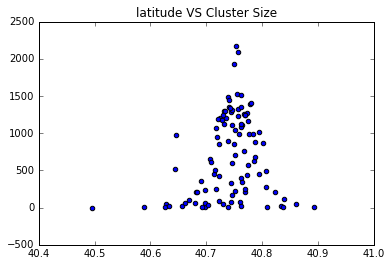

In [12]:
plt.scatter(analysis_lat,Cluster_size)
plt.title("latitude VS Cluster Size")
plt.show()

## Training data and testing data

In [13]:
#use 80% of data for train, use 20% of data for test
train_size=int(len(Cluster_size)*0.8)
test_size=int(len(Cluster_size)*0.2)
train_feature=Cluster_size[:train_size]
train_response=Cluster_center[:train_size]
test_feature=Cluster_size[test_size:]
test_response=Cluster_center[test_size:]

## Validation - coefficient of determination (R^2)
in order to check how well our model perform for prediction, we use coefficient of determination (R^2) and Mean Squared Error(MSE) to evaluate our model.

In [14]:
#coefficient of determination (R^2)
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

print (fit_model_and_score(train_feature, train_response,
                           test_feature, test_response))


(0.027825963041113948, 0.02908223456433277)


## MSE

In [15]:
#use mean squared error to evaluation model
from sklearn.metrics import mean_squared_error

MSE_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
MSE_model.fit(train_feature, train_response)
X_MSE=(test_feature)
y_MSE = MSE_model.predict(X_MSE)
mean_squared_error(test_response, y_MSE)


0.0047328531480491124

## Prediction
we fit sizes from Clusters with centers from Clusters. Next, we use the cluster that has max size as input to predict best location for pick up

In [16]:
#predict best location

X=Cluster_size
y=Cluster_center

prediction_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
prediction_model.fit(X, y)
X_predict=([max(Cluster_size)])
y_predict = prediction_model.predict(X_predict)
y_predict


array([[-73.9752935 ,  40.76064827]])

## Visualization
For Visualization, we use randint function to generate values for 100 different colors, we use scatter plot with 100 different colors to see clusters that Kmean created. Also, we use scatter plot to create visualization for prediction, we show predicted point in red and actual point in yellow for our visualization.

In [17]:
#prepare for visualization
max_size_cluster=0


for data in y_predict:
    visual_x=data[[0]]
    visual_y=data[[1]]
    
for i in range(len(Cluster_size)):
    if (Cluster_size[i]==Cluster_size.max()):
        max_size_cluster=i
        
actual_value=kmeans_n.cluster_centers_[max_size_cluster]
actual_x=actual_value[0]
actual_y=actual_value[1]

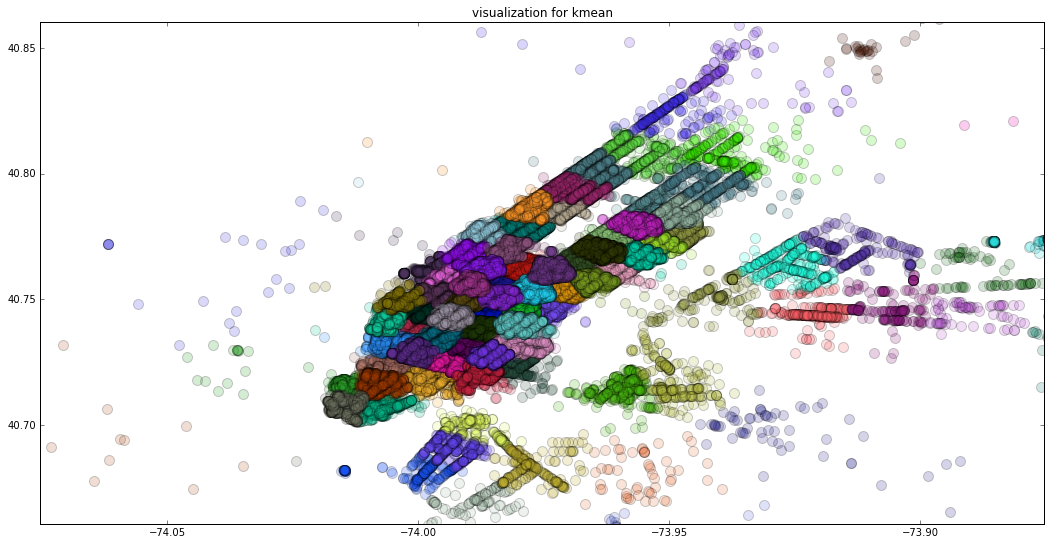

In [18]:
#visualization for kmean cluster
from random import randint
colors = []

for i in range(my_cluster):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

plt.figure(figsize=(18,9))
for i in range(my_cluster):
    my_cluster_df=df_select[df_select['Cluster']==i]
    lon_x=my_cluster_df.pickup_longitude.values
    lat_y=my_cluster_df.pickup_latitude.values
    plt.scatter(lon_x,lat_y,alpha=0.2,s=100,c=colors[i])

plt.axis([visual_x-0.1,visual_x+0.1,visual_y-0.1,visual_y+0.1])
plt.title("visualization for kmean")
plt.show()


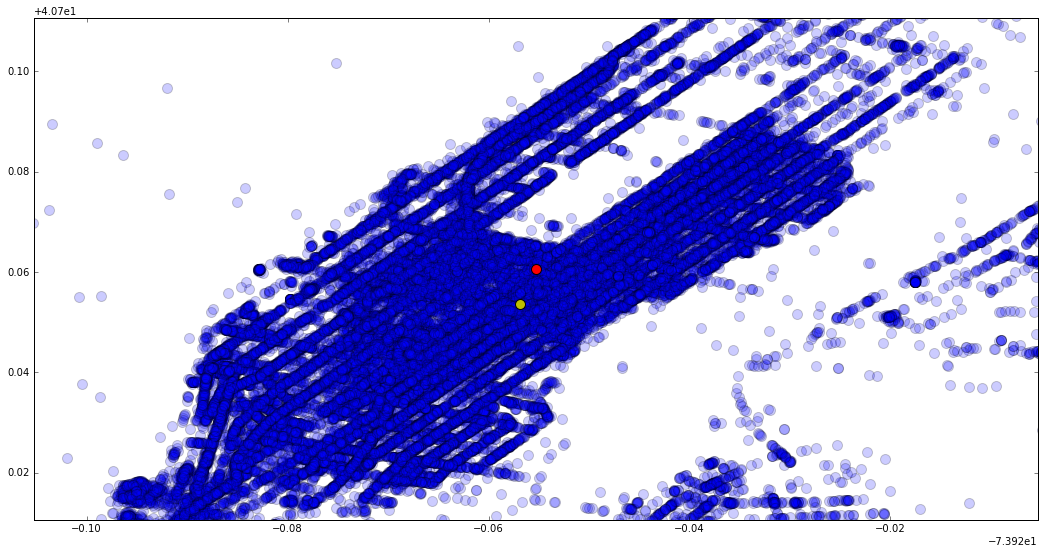

In [19]:
#scatter plot all the data for selected weekday and prediction(best location in red)
x_points=lon
y_points=lat
plt.figure(figsize=(18,9))
plt.scatter(lon,lat,alpha=0.2,s=100)
plt.scatter(visual_x,visual_y ,c='r',s=100)
plt.scatter(actual_x,actual_y ,c='y',s=100)
plt.axis([visual_x-0.05,visual_x+0.05,visual_y-0.05,visual_y+0.05])
plt.show()
